In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns


# export_graphviz: 나무 구조 생성 및 저장 
from sklearn.tree import export_graphviz
# graphviz : 나무 구조 시각화  (.dot 확장자 파일 불러오기 등)
import graphviz
# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 예측/회귀 Random Forest
from sklearn.ensemble import RandomForestRegressor
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV
# 예측/회귀 Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor


import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler

# 선형 회귀분석모델 formula(y ~ X1 + X2 + ...)
import statsmodels.formula.api as smf
# 회귀분석의 정규성 확인
from statsmodels.api import qqplot
# 샘플링 : Over-sampling 등
from imblearn.over_sampling import SMOTE
# 로지스틱 회귀
from statsmodels.api import Logit

In [169]:
import warnings
warnings.filterwarnings('ignore')

plt.rc('font',family='NanumGothic ECO')
plt.rc('axes',unicode_minus=False)

In [170]:
df_raw = pd.read_csv("/home/piai/preprocessed_scale.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   scale             994 non-null    int64 
 1   steel_kind        994 non-null    object
 2   pt_thick          994 non-null    int64 
 3   pt_width          994 non-null    int64 
 4   pt_length         994 non-null    int64 
 5   hsb               994 non-null    object
 6   fur_heat_temp     994 non-null    int64 
 7   fur_heat_time     994 non-null    int64 
 8   fur_soak_temp     994 non-null    int64 
 9   fur_soak_time     994 non-null    int64 
 10  rolling_method    994 non-null    object
 11  rolling_temp      994 non-null    int64 
 12  descaling_count   994 non-null    int64 
 13  fur_preheat_time  994 non-null    int64 
 14  furnace           994 non-null    object
dtypes: int64(11), object(4)
memory usage: 116.6+ KB


In [171]:
# 명목형 변수 목록
obj_cols = df_raw.select_dtypes("object").columns

for col in obj_cols:
    _n = len(df_raw[col].value_counts())
    print(col, ":", str(_n))

steel_kind : 2
hsb : 2
rolling_method : 2
furnace : 6


# 4. 모델링

## 모델링 전 오버샘플링

In [172]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성 
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,rolling_temp,descaling_count,...,hsb_미적용,hsb_적용,rolling_method_CR(제어압연),rolling_method_TMCP(온도제어),furnace_1호기1열,furnace_1호기2열,furnace_2호기1열,furnace_2호기2열,furnace_3호기1열,furnace_3호기2열
0,0,32,3700,15100,1144,116,1133,59,934,8,...,0,1,0,1,1,0,0,0,0,0
1,0,32,3700,15100,1144,122,1135,53,937,8,...,0,1,0,1,0,1,0,0,0,0
2,0,33,3600,19200,1129,116,1121,55,889,8,...,0,1,0,1,0,0,1,0,0,0
3,0,33,3600,19200,1152,125,1127,68,885,8,...,0,1,0,1,0,0,0,1,0,0
4,0,38,3100,13300,1140,134,1128,48,873,8,...,0,1,0,1,0,0,0,0,1,0


In [173]:
# 데이터 분리:설명변수, 목표변수 구분
df_raw_x = df_raw_dummy.drop("scale", axis = 1, inplace = False)
df_raw_y = df_raw_dummy["scale"] 

# 데이터 분할 train_test_split(X: 설명변수, Y: 목표변수, test_size = test 데이터 비율)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
    df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234) 

print("분할 전 설명변수 데이터 :", df_raw_x.shape)
print("분할 후 설명변수 데이터 :Train", df_train_x.shape, "  Test",df_test_x.shape)

분할 전 설명변수 데이터 : (994, 22)
분할 후 설명변수 데이터 :Train (695, 22)   Test (299, 22)


In [174]:
# 목표변수 빈도 확인
print(df_raw.value_counts(["scale"]),"\n")
print("scale = 1 비율  ", df_raw.value_counts(df_raw["scale"]==1)/len(df_raw))

scale
0        684
1        310
dtype: int64 

scale = 1 비율   scale
False    0.688129
True     0.311871
dtype: float64


In [175]:
# Over-sampling 설정
sm = SMOTE(sampling_strategy='auto', random_state=1234)

# train데이터를 이용한 Over-sampling
x_resampled, y_resampled = sm.fit_resample(df_train_x,df_train_y)

# 결과 확인
print('Over-Sampling 전:\n',df_train_y.value_counts(),"\n")
print('Over-Sampling 후 Train X: {}'.format(x_resampled.shape))
print('Over-Sampling 후 Train Y: {} \n'.format(y_resampled.shape))

print("Over-Sampling 후 '1':{}".format(sum(y_resampled==1)))
print("Over-Sampling 후 '0':{}".format(sum(y_resampled==0)))

Over-Sampling 전:
 0    473
1    222
Name: scale, dtype: int64 

Over-Sampling 후 Train X: (946, 22)
Over-Sampling 후 Train Y: (946,) 

Over-Sampling 후 '1':473
Over-Sampling 후 '0':473


# 4-1 로지스틱 회귀분석

In [176]:
# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report

In [177]:
# df_train_y를 데이터프레임으로 변환하고 컬럼명을 'scale'로 지정
df_train_y = y_resampled.to_frame(name="scale")
df_test_y = df_test_y.to_frame(name="scale")

# df_train_x와 df_train_y를 열 방향으로 합치기
df_train = pd.concat([x_resampled, df_train_y], axis=1)
df_test = pd.concat([df_test_x, df_test_y], axis=1)

In [178]:
# 'furnace' 더미 변수를 원래 범주형 변수로 합치기
furnace_columns = [
    'furnace_1호기1열', 'furnace_1호기2열', 'furnace_2호기1열',
    'furnace_2호기2열', 'furnace_3호기1열', 'furnace_3호기2열'
]

# 각 행에서 가장 높은 값을 가진 열 이름을 선택하여 'furnace' 컬럼 생성
df_train['furnace'] = df_train[furnace_columns].idxmax(axis=1)

# 접두사를 제거해 원래 값으로 변환
df_train['furnace'] = df_train['furnace'].str.replace('furnace_', '')

# 더미 변수 컬럼 삭제
df_train = df_train.drop(columns=furnace_columns)

# 결과 확인
df_train['furnace'].value_counts()

# 'hsb' 더미 변수를 원래 범주형 변수로 합치기
hsb_columns = ['hsb_적용', 'hsb_미적용']
df_train['hsb'] = df_train[hsb_columns].idxmax(axis=1).str.replace('hsb_', '')
df_train = df_train.drop(columns=hsb_columns)

# 'steel_kind' 더미 변수를 원래 범주형 변수로 합치기
steel_kind_columns = ['steel_kind_C', 'steel_kind_T']
df_train['steel_kind'] = df_train[steel_kind_columns].idxmax(axis=1).str.replace('steel_kind_', '')
df_train = df_train.drop(columns=steel_kind_columns)

# 'rolling_method' 더미 변수를 원래 범주형 변수로 합치기
rolling_method_columns = ['rolling_method_CR(제어압연)', 'rolling_method_TMCP(온도제어)']
df_train['rolling_method'] = df_train[rolling_method_columns].idxmax(axis=1).str.replace('rolling_method_', '')
df_train = df_train.drop(columns=rolling_method_columns)

In [179]:
# 'furnace' 더미 변수를 원래 범주형 변수로 합치기
furnace_columns = [
    'furnace_1호기1열', 'furnace_1호기2열', 'furnace_2호기1열',
    'furnace_2호기2열', 'furnace_3호기1열', 'furnace_3호기2열'
]

# 각 행에서 가장 높은 값을 가진 열 이름을 선택하여 'furnace' 컬럼 생성
df_test['furnace'] = df_test[furnace_columns].idxmax(axis=1)

# 접두사를 제거해 원래 값으로 변환
df_test['furnace'] = df_test['furnace'].str.replace('furnace_', '')

# 더미 변수 컬럼 삭제
df_test = df_test.drop(columns=furnace_columns)

# 결과 확인
df_test['furnace'].value_counts()

# 'hsb' 더미 변수를 원래 범주형 변수로 합치기
hsb_columns = ['hsb_적용', 'hsb_미적용']
df_test['hsb'] = df_test[hsb_columns].idxmax(axis=1).str.replace('hsb_', '')
df_test = df_test.drop(columns=hsb_columns)

# 'steel_kind' 더미 변수를 원래 범주형 변수로 합치기
steel_kind_columns = ['steel_kind_C', 'steel_kind_T']
df_test['steel_kind'] = df_test[steel_kind_columns].idxmax(axis=1).str.replace('steel_kind_', '')
df_test = df_test.drop(columns=steel_kind_columns)

# 'rolling_method' 더미 변수를 원래 범주형 변수로 합치기
rolling_method_columns = ['rolling_method_CR(제어압연)', 'rolling_method_TMCP(온도제어)']
df_test['rolling_method'] = df_test[rolling_method_columns].idxmax(axis=1).str.replace('rolling_method_', '')
df_test = df_test.drop(columns=rolling_method_columns)

In [180]:
# select_dtypes: 특정 변수 타입을 선택/제외하여 데이터 추출
df_train_char = df_train.select_dtypes(include = "object")
df_train_numeric = df_train.select_dtypes(exclude = "object")

# Data Scaling
scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_train_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns = df_train_numeric.columns)

# 문자 데이터 + 숫자 데이터
df_train = pd.concat([df_numeric_scaled, df_train_char],axis = 1)
df_train

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,rolling_temp,descaling_count,fur_preheat_time,scale,furnace,hsb,steel_kind,rolling_method
0,-0.010666,-0.339880,-0.448032,0.289542,-0.534055,0.433292,-0.377567,1.115496,-0.278152,0.399607,1.0,2호기1열,적용,C,CR(제어압연)
1,-0.362658,-0.550047,0.122657,0.591035,0.184886,1.039196,-0.685878,1.131088,-0.934340,0.399607,1.0,2호기2열,적용,C,CR(제어압연)
2,-0.538654,0.080454,1.109794,-0.866182,1.622769,-0.354384,-0.069256,0.039655,1.034225,1.731185,-1.0,2호기1열,적용,C,CR(제어압연)
3,-0.597319,-0.550047,0.022400,-0.765684,-1.213055,-0.172612,-0.583107,0.273534,1.034225,1.591019,1.0,3호기1열,미적용,C,CR(제어압연)
4,-0.655985,-0.550047,1.356578,1.043274,-0.334349,0.554473,-0.891418,0.678923,1.034225,0.329524,-1.0,3호기1열,적용,C,CR(제어압연)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,2.159950,-0.236898,-1.909535,-0.765684,1.183416,-1.323830,0.547366,-1.457166,-2.246717,0.189358,1.0,1호기1열,적용,T,CR(제어압연)
942,0.575987,0.206555,-1.447277,0.239293,-0.094702,0.312111,-0.737263,1.255823,-0.934340,-0.721722,1.0,1호기1열,적용,C,CR(제어압연)
943,-0.362658,-0.129713,0.641829,0.138795,0.624239,0.615063,-0.480337,0.772474,-0.934340,-1.422553,1.0,1호기1열,적용,C,CR(제어압연)
944,-0.127997,-0.573165,-0.061660,-1.469168,0.344651,-0.899697,-1.199729,1.006353,-0.934340,0.329524,1.0,1호기1열,적용,C,CR(제어압연)


In [181]:
# select_dtypes: 특정 변수 타입을 선택/제외하여 데이터 추출
# 문자형 데이터 추출 및 인덱스 초기화
df_test_char = df_test.select_dtypes(include="object").reset_index(drop=True)

# 숫자형 데이터 추출 및 인덱스 초기화
df_test_numeric = df_test.select_dtypes(exclude="object").reset_index(drop=True)

# Data Scaling
scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_test_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns = df_test_numeric.columns)
# 문자 데이터 + 숫자 데이터
df_test = pd.concat([df_numeric_scaled, df_test_char],axis = 1)
df_test

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,rolling_temp,descaling_count,fur_preheat_time,scale,furnace,hsb,steel_kind,rolling_method
0,-0.516809,-0.753561,0.420074,0.600014,-0.777147,0.416411,-0.241923,1.053245,0.845207,-0.644787,1.548460,3호기1열,적용,C,CR(제어압연)
1,-0.626792,0.648397,0.805509,-0.287432,-0.931801,1.074543,-0.536566,0.137405,0.845207,1.020077,-0.645803,2호기1열,적용,C,CR(제어압연)
2,-0.791767,-0.152722,1.248046,0.740137,-0.970464,0.595901,0.101828,-0.312481,0.845207,-0.578192,-0.645803,1호기2열,적용,C,CR(제어압연)
3,-0.736775,-0.152722,1.283735,0.506599,-0.738484,0.416411,0.592900,-0.087538,0.845207,1.153266,-0.645803,2호기2열,적용,C,CR(제어압연)
4,-0.241852,-1.354399,-0.029601,0.366476,-0.545167,0.835222,0.052720,1.085380,-0.405867,-0.178625,1.548460,2호기2열,적용,C,CR(제어압연)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,-0.461818,-1.354399,0.477175,0.459891,-0.197196,0.835222,-0.536566,1.213919,0.845207,0.620510,1.548460,1호기2열,적용,C,CR(제어압연)
295,-0.571801,-0.553281,0.669893,0.833552,-0.931801,0.835222,0.052720,0.635494,0.845207,-0.977759,1.548460,1호기2열,미적용,C,CR(제어압연)
296,2.617704,-0.353001,-1.935365,-1.548539,0.808052,-1.617818,-0.487459,-1.501465,-1.656940,-0.178625,-0.645803,1호기2열,적용,T,CR(제어압연)
297,-0.736775,0.448117,0.905437,1.487460,-0.545167,0.895053,-0.683887,0.057069,0.845207,0.487321,-0.645803,2호기2열,적용,C,CR(제어압연)


In [182]:
df_train["scale"] = np.where(df_train["scale"]> 0, 1, 0)
df_test["scale"] = np.where(df_test["scale"]> 0, 1, 0)

In [183]:
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula("""scale ~  pt_width +  fur_heat_temp + fur_heat_time
+ fur_soak_temp  + rolling_temp + descaling_count  + C(steel_kind)+ C(furnace)""", df_train)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.353292
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  946
Model:                          Logit   Df Residuals:                      933
Method:                           MLE   Df Model:                           12
Date:                Tue, 05 Nov 2024   Pseudo R-squ.:                  0.4903
Time:                        19:50:56   Log-Likelihood:                -334.21
converged:                       True   LL-Null:                       -655.72
Covariance Type:            nonrobust   LLR p-value:                6.866e-130
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.9033      0.217      8.754      0.000       1.477       2.329
C(

<Axes: >

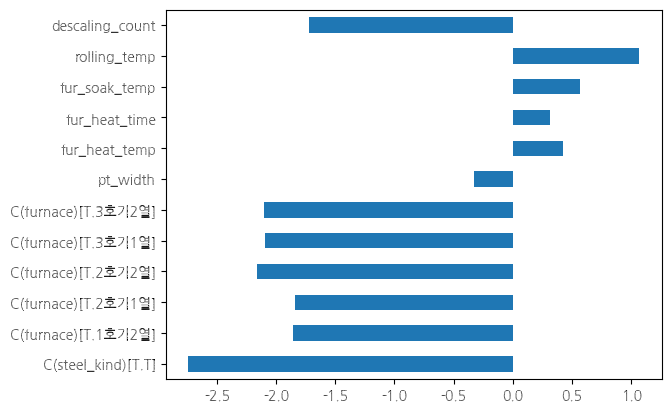

In [184]:
# 설명변수 중요도
df_log_scaled_coef = pd.DataFrame({"Coef": log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y = "Coef", legend = False)

In [185]:
log_result.params

Intercept              1.903258
C(steel_kind)[T.T]    -2.740397
C(furnace)[T.1호기2열]   -1.857150
C(furnace)[T.2호기1열]   -1.839314
C(furnace)[T.2호기2열]   -2.164588
C(furnace)[T.3호기1열]   -2.089184
C(furnace)[T.3호기2열]   -2.099098
pt_width              -0.329683
fur_heat_temp          0.424970
fur_heat_time          0.313195
fur_soak_temp          0.566740
rolling_temp           1.069387
descaling_count       -1.725108
dtype: float64

In [186]:
# train 데이터 예측
y_pred_train = log_result.predict(df_train)
# 0과 1의 값을 가진 class로 변환
y_pred_train_class = (y_pred_train > 0.5).astype(int)  # 0.5 : “1/0” 판정 임계값(1 발생 확률) 변경 가능 
print("Train 예측 결과 \n", y_pred_train_class.head(), "\n")
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train["scale"],y_pred_train_class)),"\n")

# test 데이터 예측
y_pred_test = log_result.predict(df_test)
# 0과 1의 값을 가진 class로 변환
y_pred_test_class = (y_pred_test > 0.5).astype(int)
print("Test 예측 결과 \n", y_pred_test_class.head(),"\n")
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["scale"],y_pred_test_class)),"\n")

Train 예측 결과 
 0    1
1    1
2    0
3    0
4    0
dtype: int64 

Confusion Matrix: 
[[405  68]
 [ 79 394]] 

Test 예측 결과 
 0    0
1    0
2    0
3    0
4    1
dtype: int64 

Confusion Matrix: 
[[160  51]
 [ 26  62]] 



In [187]:
# 실제 train 데이터와 예측 결과 비교
print("Train 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_train["scale"], y_pred_train_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train["scale"],y_pred_train_class)),"\n")
print(classification_report(df_train["scale"], y_pred_train_class, digits=3))

# 실제 train 데이터와 예측 결과 비교
print("Test 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test["scale"], y_pred_test_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["scale"],y_pred_test_class)),"\n")
print(classification_report(df_test["scale"], y_pred_test_class, digits=3))

Train 예측/분류 결과
Accuracy: 0.845

Confusion Matrix: 
[[405  68]
 [ 79 394]] 

              precision    recall  f1-score   support

           0      0.837     0.856     0.846       473
           1      0.853     0.833     0.843       473

    accuracy                          0.845       946
   macro avg      0.845     0.845     0.845       946
weighted avg      0.845     0.845     0.845       946

Test 예측/분류 결과
Accuracy: 0.742

Confusion Matrix: 
[[160  51]
 [ 26  62]] 

              precision    recall  f1-score   support

           0      0.860     0.758     0.806       211
           1      0.549     0.705     0.617        88

    accuracy                          0.742       299
   macro avg      0.704     0.731     0.711       299
weighted avg      0.769     0.742     0.750       299



# 4-2 의사결정트리, 랜덤포레스트, XGBOOST

In [188]:
# 실행결과 경고메시지 출력 제외
import warnings

warnings.filterwarnings('ignore')

# 데이터 구성:Series, DataFrame
import pandas as pd

# 배열 구성
import numpy as np

# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib

# export_graphviz: 나무 구조 생성 및 저장 
from sklearn.tree import export_graphviz

# graphviz : 나무 구조 시각화  (.dot 확장자 파일 불러오기 등)
import graphviz

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split

# 예측/회귀 Decision Tree
from sklearn.tree import DecisionTreeClassifier

# 예측/회귀 Random Forest
from sklearn.ensemble import RandomForestClassifier

# 예측/회귀 xgboost  
from xgboost import XGBClassifier

# 모델 성능 평가: Precision, Recall, F1 Score, ROC Curve, AUC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score

# Check the Frequency of Variable
from collections import Counter

# Scale 변환:평균,표준편차 기준
from sklearn.preprocessing import StandardScaler

# 변수 중요도 확인: F1 점수 기준
from xgboost import plot_importance

# 샘플링 : Over-sampling 등
from imblearn.over_sampling import SMOTE

# 분류모델 통합 평가: 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 등
def eval_class_model(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    
    print('오차행렬:\n', confusion, '\n')
    print('정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1    : {:.4f}'.format(F1))
    print('AUC   : {:.4f}'.format(AUC))

# 최적 모델, 파라미터 탐색
from sklearn.model_selection import RandomizedSearchCV

# 맑은 고딕 적용
matplotlib.rc("font", family = "NanumGothic ECO")
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)

In [189]:
# 데이터 불러오기
df_raw = pd.read_csv("/home/piai/preprocessed_scale.csv")
df_raw.head()

# Data 구조 확인
print("Data 구조:", df_raw.shape)
print()
print("변수 : ", df_raw.columns)

# 결측치 확인 (각 열별 결측치 개수를 확인)
df_raw.isnull().sum(axis=0)

Data 구조: (994, 15)

변수 :  Index(['scale', 'steel_kind', 'pt_thick', 'pt_width', 'pt_length', 'hsb',
       'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp', 'fur_soak_time',
       'rolling_method', 'rolling_temp', 'descaling_count', 'fur_preheat_time',
       'furnace'],
      dtype='object')


scale               0
steel_kind          0
pt_thick            0
pt_width            0
pt_length           0
hsb                 0
fur_heat_temp       0
fur_heat_time       0
fur_soak_temp       0
fur_soak_time       0
rolling_method      0
rolling_temp        0
descaling_count     0
fur_preheat_time    0
furnace             0
dtype: int64

In [190]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()


,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,rolling_temp,descaling_count,...,hsb_미적용,hsb_적용,rolling_method_CR(제어압연),rolling_method_TMCP(온도제어),furnace_1호기1열,furnace_1호기2열,furnace_2호기1열,furnace_2호기2열,furnace_3호기1열,furnace_3호기2열
0,0,32,3700,15100,1144,116,1133,59,934,8,...,0,1,0,1,1,0,0,0,0,0
1,0,32,3700,15100,1144,122,1135,53,937,8,...,0,1,0,1,0,1,0,0,0,0
2,0,33,3600,19200,1129,116,1121,55,889,8,...,0,1,0,1,0,0,1,0,0,0
3,0,33,3600,19200,1152,125,1127,68,885,8,...,0,1,0,1,0,0,0,1,0,0
4,0,38,3100,13300,1140,134,1128,48,873,8,...,0,1,0,1,0,0,0,0,1,0


In [191]:
# 데이터 분리:설명변수, 목표변수 구분
df_raw_x = df_raw_dummy.drop("scale", axis = 1, inplace = False)
df_raw_y = df_raw_dummy["scale"] 

# 데이터 분할 train_test_split(X: 설명변수, Y: 목표변수, test_size = test 데이터 비율)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
    df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234) 

print("분할 전 설명변수 데이터 :", df_raw_x.shape)
print("분할 후 설명변수 데이터 :Train", df_train_x.shape, "  Test",df_test_x.shape)


분할 전 설명변수 데이터 : (994, 22)
분할 후 설명변수 데이터 :Train (695, 22)   Test (299, 22)


In [192]:
# 목표변수 빈도 확인
print(df_raw.value_counts(["scale"]),"\n")
print("scale = 1 비율  ", df_raw.value_counts(df_raw["scale"]==1)/len(df_raw))

scale
0        684
1        310
dtype: int64 

scale = 1 비율   scale
False    0.688129
True     0.311871
dtype: float64


In [193]:
# Over-sampling 설정
sm = SMOTE(sampling_strategy='auto', random_state=1234)

# train데이터를 이용한 Over-sampling
x_resampled, y_resampled = sm.fit_resample(df_train_x,df_train_y)

# 결과 확인
print('Over-Sampling 전:\n',df_train_y.value_counts(),"\n")
print('Over-Sampling 후 Train X: {}'.format(x_resampled.shape))
print('Over-Sampling 후 Train Y: {} \n'.format(y_resampled.shape))

print("Over-Sampling 후 '1':{}".format(sum(y_resampled==1)))
print("Over-Sampling 후 '0':{}".format(sum(y_resampled==0)))

# 변수명
v_feature_name = x_resampled.columns

Over-Sampling 전:
 0    473
1    222
Name: scale, dtype: int64 

Over-Sampling 후 Train X: (946, 22)
Over-Sampling 후 Train Y: (946,) 

Over-Sampling 후 '1':473
Over-Sampling 후 '0':473


## 의사결정트리

In [194]:
# RandomizedSearchCV를 이용한 최적 parameter로 커스텀
'''
estimator = DecisionTreeClassifier()

# 구하고자 하는 parameter와 범위 (분류용 criterion으로 변경)
param_grid = {
    "max_depth": [int(x) for x in range(1, 31)],            # 최대 깊이
    "min_samples_split": [int(x) for x in range(2, 51)],    # 노드를 분할하기 위한 최소 샘플 수
    "min_samples_leaf": [int(x) for x in range(1, 31)]      # 리프 노드가 되기 위한 최소 샘플 수
}

# 설명력이 높은 최적 parameter 찾기
rand_dt = RandomizedSearchCV(estimator,
    param_distributions=param_grid,
    n_iter=1000,
    scoring="accuracy",
    n_jobs=-1, 
    random_state=1234
)
rand_dt.fit(x_resampled, y_resampled)

print("best estimator model: \n{}".format(rand_dt.best_estimator_))
print("\nbest parameter: \n{}".format(rand_dt.best_params_))
print("\nbest score: \n{}".format(rand_dt.best_score_.round(3)))'''

'\nestimator = DecisionTreeClassifier()\n\n# 구하고자 하는 parameter와 범위 (분류용 criterion으로 변경)\nparam_grid = {\n    "max_depth": [int(x) for x in range(1, 31)],            # 최대 깊이\n    "min_samples_split": [int(x) for x in range(2, 51)],    # 노드를 분할하기 위한 최소 샘플 수\n    "min_samples_leaf": [int(x) for x in range(1, 31)]      # 리프 노드가 되기 위한 최소 샘플 수\n}\n\n# 설명력이 높은 최적 parameter 찾기\nrand_dt = RandomizedSearchCV(estimator,\n    param_distributions=param_grid,\n    n_iter=1000,\n    scoring="accuracy",\n    n_jobs=-1, \n    random_state=1234\n)\nrand_dt.fit(x_resampled, y_resampled)\n\nprint("best estimator model: \n{}".format(rand_dt.best_estimator_))\nprint("\nbest parameter: \n{}".format(rand_dt.best_params_))\nprint("\nbest score: \n{}".format(rand_dt.best_score_.round(3)))'

In [195]:
# 모델 생성
rand_dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=9, random_state=1234)
rand_dt.fit(x_resampled, y_resampled)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=9,
                       random_state=1234)

In [196]:
# 평가
y_pred = rand_dt.predict(df_test_x)

# train 데이터 정확도
print("Train Accuracy: {0:.3f}\n".format(rand_dt.score(x_resampled, y_resampled)))

# test 데이터 정확도
print("Accuracy on test set: {:.3f}\n".format(rand_dt.score(df_test_x, df_test_y)))

print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가 
print(classification_report(df_test_y, y_pred, digits=3))

Train Accuracy: 0.998

Accuracy on test set: 0.993

Test Confusion matrix: 
[[210   1]
 [  1  87]]
              precision    recall  f1-score   support

           0      0.995     0.995     0.995       211
           1      0.989     0.989     0.989        88

    accuracy                          0.993       299
   macro avg      0.992     0.992     0.992       299
weighted avg      0.993     0.993     0.993       299



In [197]:
# 설명변수 중요도
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rand_dt.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)


,Feature,Importance
7,rolling_temp,0.450
13,hsb_적용,0.212
0,pt_thick,0.129
5,fur_soak_temp,0.118
8,descaling_count,0.082
3,fur_heat_temp,0.007
4,fur_heat_time,0.002
2,pt_length,0.001
15,rolling_method_TMCP(온도제어),0.000
20,furnace_3호기1열,0.000


Text(0, 0.5, '설명변수')

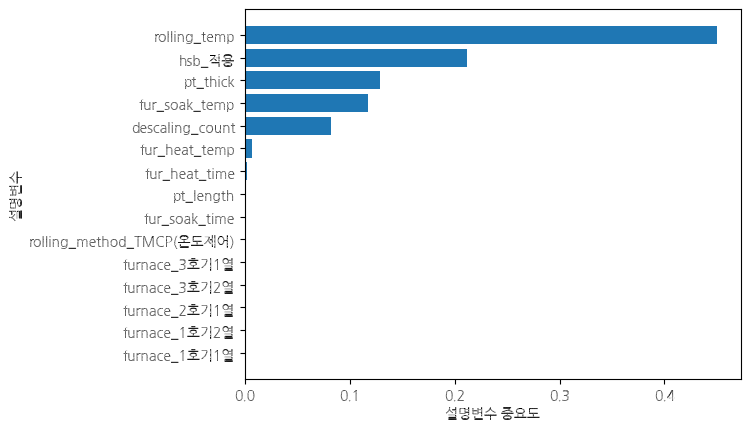

In [198]:
# 설명변수 중요도 그래프
# sort_values : 중요도가 높은 변수를 상위에 그림. 
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))

df_top = df_importance.tail(15)
coordinates = range(len(df_top))
plt.barh(y = coordinates, width = df_top["Importance"])
plt.yticks(coordinates, df_top["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## 랜덤포레스트

In [199]:
# RandomForestClassifier 모델 설정
'''
estimator = RandomForestClassifier()

# RandomForestClassifier에 맞는 하이퍼파라미터 범위 설정
param_grid = {
    "n_estimators": [int(x) for x in range(50, 501, 50)],   # 트리 개수
    "max_depth": [int(x) for x in range(1, 31)],            # 최대 깊이
    "min_samples_split": [int(x) for x in range(2, 51)],    # 노드를 분할하기 위한 최소 샘플 수
    "min_samples_leaf": [int(x) for x in range(1, 31)]      # 리프 노드가 되기 위한 최소 샘플 수
}

# RandomizedSearchCV 설정 및 학습
rand_rf = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_grid,
    n_iter=1000,
    scoring="accuracy",   # 분류 문제에 적합한 평가지표
    n_jobs=-1,
    random_state=1234
)

# 오버샘플링된 학습 데이터 사용
rand_rf.fit(x_resampled, y_resampled)

# 최적의 결과 출력
print("Best estimator model: \n{}".format(rand_rf.best_estimator_))
print("\nBest parameter: \n{}".format(rand_rf.best_params_))
print("\nBest score: \n{}".format(rand_rf.best_score_.round(3)))'''

'\nestimator = RandomForestClassifier()\n\n# RandomForestClassifier에 맞는 하이퍼파라미터 범위 설정\nparam_grid = {\n    "n_estimators": [int(x) for x in range(50, 501, 50)],   # 트리 개수\n    "max_depth": [int(x) for x in range(1, 31)],            # 최대 깊이\n    "min_samples_split": [int(x) for x in range(2, 51)],    # 노드를 분할하기 위한 최소 샘플 수\n    "min_samples_leaf": [int(x) for x in range(1, 31)]      # 리프 노드가 되기 위한 최소 샘플 수\n}\n\n# RandomizedSearchCV 설정 및 학습\nrand_rf = RandomizedSearchCV(\n    estimator=estimator,\n    param_distributions=param_grid,\n    n_iter=1000,\n    scoring="accuracy",   # 분류 문제에 적합한 평가지표\n    n_jobs=-1,\n    random_state=1234\n)\n\n# 오버샘플링된 학습 데이터 사용\nrand_rf.fit(x_resampled, y_resampled)\n\n# 최적의 결과 출력\nprint("Best estimator model: \n{}".format(rand_rf.best_estimator_))\nprint("\nBest parameter: \n{}".format(rand_rf.best_params_))\nprint("\nBest score: \n{}".format(rand_rf.best_score_.round(3)))'

In [200]:
# 모델 생성
rand_rf = RandomForestClassifier(max_depth=16, min_samples_split=5, n_estimators=150, random_state=1234)
rand_rf.fit(x_resampled, y_resampled)


RandomForestClassifier(max_depth=16, min_samples_split=5, n_estimators=150,
                       random_state=1234)

In [201]:
# 평가
y_pred = rand_rf.predict(df_test_x)

# train 데이터 정확도
print("Train Accuracy: {0:.3f}\n".format(rand_rf.score(x_resampled, y_resampled)))

# test 데이터 정확도
print("Accuracy on test set: {:.3f}\n".format(rand_rf.score(df_test_x, df_test_y)))

print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가 
print(classification_report(df_test_y, y_pred, digits=3))

Train Accuracy: 1.000

Accuracy on test set: 0.960

Test Confusion matrix: 
[[205   6]
 [  6  82]]
              precision    recall  f1-score   support

           0      0.972     0.972     0.972       211
           1      0.932     0.932     0.932        88

    accuracy                          0.960       299
   macro avg      0.952     0.952     0.952       299
weighted avg      0.960     0.960     0.960       299



In [202]:
# 설명변수 중요도
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rand_rf.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)


,Feature,Importance
7,rolling_temp,0.250
8,descaling_count,0.126
5,fur_soak_temp,0.108
13,hsb_적용,0.100
1,pt_width,0.064
2,pt_length,0.057
3,fur_heat_temp,0.057
0,pt_thick,0.052
11,steel_kind_T,0.032
12,hsb_미적용,0.028


Text(0, 0.5, '설명변수')

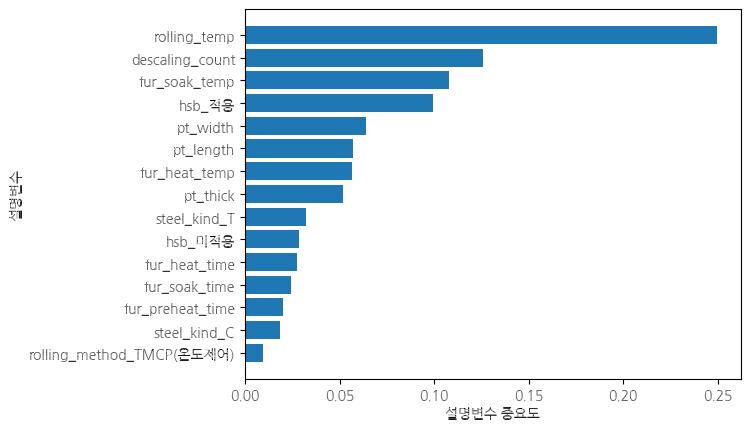

In [203]:
# 설명변수 중요도 그래프
# sort_values : 중요도가 높은 변수를 상위에 그림. 
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))

df_top = df_importance.tail(15)
coordinates = range(len(df_top))
plt.barh(y = coordinates, width = df_top["Importance"])
plt.yticks(coordinates, df_top["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## XGBOOST

In [204]:
# XGBClassifier 모델 설정
'''
estimator = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

# XGBClassifier에 맞는 하이퍼파라미터 범위 설정
param_grid = {
    "objective": ["binary:logistic"],   # 분류 문제 유형에 맞는 목표 함수
    "max_depth": [int(x) for x in range(1, 31)],                           # 최대 깊이
    "learning_rate": [lr * 0.02 for lr in range(1, 21)],                   # 학습률
    "n_estimators": [int(x) for x in range(50, 501, 50)],                  # 트리 개수
    "min_child_weight": [int(x) for x in range(1, 11)],                    # 자식 노드의 가중치 합 최소값
    "subsample": [0.5, 0.7, 0.8, 1.0],                                     # 각 트리마다 사용할 샘플 비율
    "colsample_bytree": [0.5, 0.7, 0.8, 1.0],                              # 각 트리마다 사용할 특성 비율
    "gamma": [0, 0.1, 0.2, 0.3, 0.4],                                      # 리프 노드에서 추가 분할을 위한 최소 손실 감소 값
}

# RandomizedSearchCV 설정 및 학습
rand_xgb = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_grid,
    n_iter=1000,
    scoring="accuracy",    # 분류 문제에 적합한 평가지표
    n_jobs=-1,
    random_state=1234
)

# 오버샘플링된 학습 데이터 사용
rand_xgb.fit(x_resampled, y_resampled)

# 최적의 결과 출력
print("Best estimator model: \n{}".format(rand_xgb.best_estimator_))
print("\nBest parameter: \n{}".format(rand_xgb.best_params_))
print("\nBest score: \n{}".format(rand_xgb.best_score_.round(3)))

'''

'\nestimator = XGBClassifier(use_label_encoder=False, eval_metric="logloss")\n\n# XGBClassifier에 맞는 하이퍼파라미터 범위 설정\nparam_grid = {\n    "objective": ["binary:logistic"],   # 분류 문제 유형에 맞는 목표 함수\n    "max_depth": [int(x) for x in range(1, 31)],                           # 최대 깊이\n    "learning_rate": [lr * 0.02 for lr in range(1, 21)],                   # 학습률\n    "n_estimators": [int(x) for x in range(50, 501, 50)],                  # 트리 개수\n    "min_child_weight": [int(x) for x in range(1, 11)],                    # 자식 노드의 가중치 합 최소값\n    "subsample": [0.5, 0.7, 0.8, 1.0],                                     # 각 트리마다 사용할 샘플 비율\n    "colsample_bytree": [0.5, 0.7, 0.8, 1.0],                              # 각 트리마다 사용할 특성 비율\n    "gamma": [0, 0.1, 0.2, 0.3, 0.4],                                      # 리프 노드에서 추가 분할을 위한 최소 손실 감소 값\n}\n\n# RandomizedSearchCV 설정 및 학습\nrand_xgb = RandomizedSearchCV(\n    estimator=estimator,\n    param_distributions=param_grid,\n    n_iter=1000,\n    scoring="accu

In [205]:
# 모델 생성
rd_xgboost = XGBClassifier(
    base_score=None,
    booster='gbtree',                 # 기본 부스터 설정
    colsample_bylevel=1.0,            # 트리의 각 레벨별 샘플링 비율
    colsample_bynode=1.0,             # 노드별 샘플링 비율
    colsample_bytree=0.7,             # 트리별 샘플링 비율
    enable_categorical=False,         # 범주형 특성 사용 여부
    eval_metric='logloss',            # 평가 지표
    gamma=0,                          # 노드 분할의 최소 손실 감소
    learning_rate=0.3,                # 학습률
    max_depth=5,                      # 트리 최대 깊이
    min_child_weight=1,               # 자식 노드에 필요한 최소 가중치 합
    n_estimators=500,                 # 생성할 트리 수
    n_jobs=-1,                        # 모든 CPU 코어 사용
    objective='binary:logistic',      # 이진 분류 목표 함수
    random_state=1234,                # 시드값 설정
    subsample=1.0                     # 각 트리에 사용할 데이터 비율
)

# 모델 적합
rd_xgboost.fit(x_resampled, y_resampled)

# 예측 및 모델 평가:Test  
xgb_pred_test = rd_xgboost.predict(df_test_x)

print('\n 모델 평가 : Test \n')
print("Train Accuracy: {:.3f}".format(rd_xgboost.score(x_resampled, y_resampled)))
eval_class_model(df_test_y, xgb_pred_test)
print('\n',classification_report(df_test_y, xgb_pred_test))
print("Test F1 Score:", f1_score(df_test_y, xgb_pred_test, average="binary"))



 모델 평가 : Test 

Train Accuracy: 1.000
오차행렬:
 [[210   1]
 [  3  85]] 

정확도: 0.9866
정밀도: 0.9884
재현율: 0.9659
F1    : 0.9770
AUC   : 0.9806

               precision    recall  f1-score   support

           0       0.99      1.00      0.99       211
           1       0.99      0.97      0.98        88

    accuracy                           0.99       299
   macro avg       0.99      0.98      0.98       299
weighted avg       0.99      0.99      0.99       299

Test F1 Score: 0.9770114942528736


{'pt_thick': 100.0, 'pt_width': 146.0, 'pt_length': 146.0, 'fur_heat_temp': 143.0, 'fur_heat_time': 124.0, 'fur_soak_temp': 144.0, 'fur_soak_time': 106.0, 'rolling_temp': 259.0, 'descaling_count': 254.0, 'fur_preheat_time': 99.0, 'steel_kind_C': 1.0, 'steel_kind_T': 38.0, 'hsb_미적용': 6.0, 'hsb_적용': 18.0, 'rolling_method_CR(제어압연)': 2.0, 'rolling_method_TMCP(온도제어)': 1.0, 'furnace_1호기2열': 10.0, 'furnace_2호기1열': 1.0, 'furnace_2호기2열': 2.0, 'furnace_3호기1열': 7.0, 'furnace_3호기2열': 2.0}


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

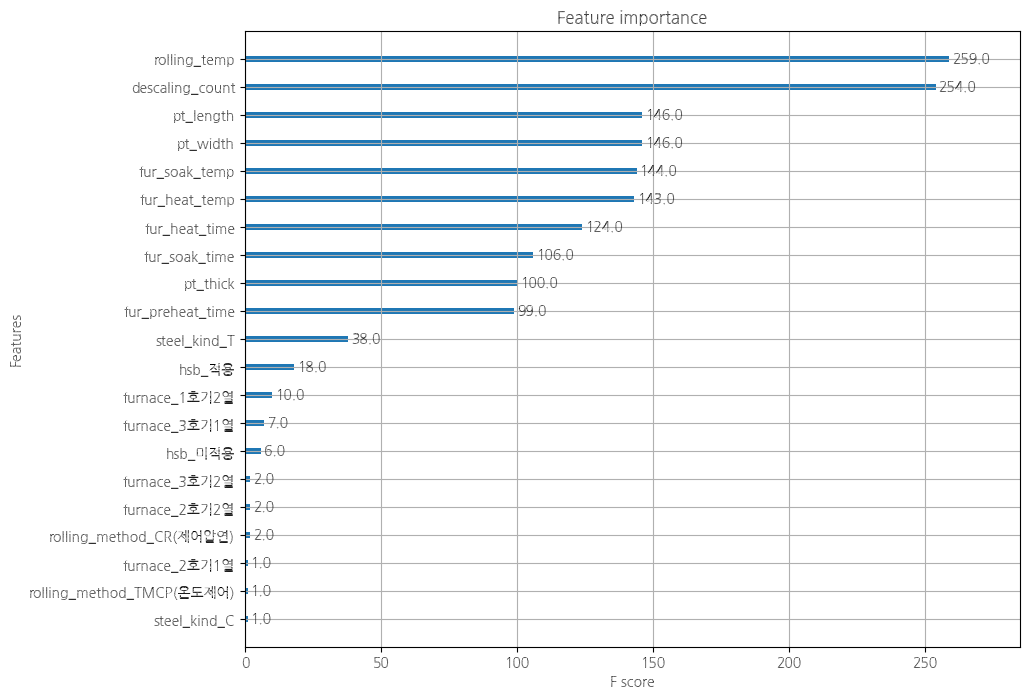

In [206]:
# 변수 중요도 확인 
from xgboost import plot_importance  # F1 score 기준으로 변수 중요도 표시(변경 가능)
print(rd_xgboost.get_booster().get_fscore())

fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(rd_xgboost, ax=ax)

# 4-3 SVM

In [207]:
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report 


In [208]:
df_raw = pd.read_csv("/home/piai/preprocessed_scale.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   scale             994 non-null    int64 
 1   steel_kind        994 non-null    object
 2   pt_thick          994 non-null    int64 
 3   pt_width          994 non-null    int64 
 4   pt_length         994 non-null    int64 
 5   hsb               994 non-null    object
 6   fur_heat_temp     994 non-null    int64 
 7   fur_heat_time     994 non-null    int64 
 8   fur_soak_temp     994 non-null    int64 
 9   fur_soak_time     994 non-null    int64 
 10  rolling_method    994 non-null    object
 11  rolling_temp      994 non-null    int64 
 12  descaling_count   994 non-null    int64 
 13  fur_preheat_time  994 non-null    int64 
 14  furnace           994 non-null    object
dtypes: int64(11), object(4)
memory usage: 116.6+ KB


In [209]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성 
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,rolling_temp,descaling_count,...,hsb_미적용,hsb_적용,rolling_method_CR(제어압연),rolling_method_TMCP(온도제어),furnace_1호기1열,furnace_1호기2열,furnace_2호기1열,furnace_2호기2열,furnace_3호기1열,furnace_3호기2열
0,0,32,3700,15100,1144,116,1133,59,934,8,...,0,1,0,1,1,0,0,0,0,0
1,0,32,3700,15100,1144,122,1135,53,937,8,...,0,1,0,1,0,1,0,0,0,0
2,0,33,3600,19200,1129,116,1121,55,889,8,...,0,1,0,1,0,0,1,0,0,0
3,0,33,3600,19200,1152,125,1127,68,885,8,...,0,1,0,1,0,0,0,1,0,0
4,0,38,3100,13300,1140,134,1128,48,873,8,...,0,1,0,1,0,0,0,0,1,0


In [210]:
# 데이터 분리:설명변수, 목표변수 구분
df_raw_x = df_raw_dummy.drop("scale", axis = 1, inplace = False)
df_raw_y = df_raw_dummy["scale"] 

# 데이터 분할 train_test_split(X: 설명변수, Y: 목표변수, test_size = test 데이터 비율)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
    df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234) 

print("분할 전 설명변수 데이터 :", df_raw_x.shape)
print("분할 후 설명변수 데이터 :Train", df_train_x.shape, "  Test",df_test_x.shape)

분할 전 설명변수 데이터 : (994, 22)
분할 후 설명변수 데이터 :Train (695, 22)   Test (299, 22)


In [211]:
# 목표변수 빈도 확인
print(df_raw.value_counts(["scale"]),"\n")
print("scale = 1 비율  ", df_raw.value_counts(df_raw["scale"]==1)/len(df_raw))

scale
0        684
1        310
dtype: int64 

scale = 1 비율   scale
False    0.688129
True     0.311871
dtype: float64


In [212]:
# Over-sampling 설정
sm = SMOTE(sampling_strategy='auto', random_state=1234)

# train데이터를 이용한 Over-sampling
x_resampled, y_resampled = sm.fit_resample(df_train_x,df_train_y)

# 결과 확인
print('Over-Sampling 전:\n',df_train_y.value_counts(),"\n")
print('Over-Sampling 후 Train X: {}'.format(x_resampled.shape))
print('Over-Sampling 후 Train Y: {} \n'.format(y_resampled.shape))

print("Over-Sampling 후 '1':{}".format(sum(y_resampled==1)))
print("Over-Sampling 후 '0':{}".format(sum(y_resampled==0)))

Over-Sampling 전:
 0    473
1    222
Name: scale, dtype: int64 

Over-Sampling 후 Train X: (946, 22)
Over-Sampling 후 Train Y: (946,) 

Over-Sampling 후 '1':473
Over-Sampling 후 '0':473


In [213]:
# df_train_y를 데이터프레임으로 변환하고 컬럼명을 'scale'로 지정
df_train_y = y_resampled.to_frame(name="scale")
df_test_y = df_test_y.to_frame(name="scale")

# df_train_x와 df_train_y를 열 방향으로 합치기
df_train = pd.concat([x_resampled, df_train_y], axis=1)
df_test = pd.concat([df_test_x, df_test_y], axis=1)

In [214]:
# 'furnace' 더미 변수를 원래 범주형 변수로 합치기
furnace_columns = [
    'furnace_1호기1열', 'furnace_1호기2열', 'furnace_2호기1열',
    'furnace_2호기2열', 'furnace_3호기1열', 'furnace_3호기2열'
]

# 각 행에서 가장 높은 값을 가진 열 이름을 선택하여 'furnace' 컬럼 생성
df_train['furnace'] = df_train[furnace_columns].idxmax(axis=1)

# 접두사를 제거해 원래 값으로 변환
df_train['furnace'] = df_train['furnace'].str.replace('furnace_', '')

# 더미 변수 컬럼 삭제
df_train = df_train.drop(columns=furnace_columns)

# 결과 확인
df_train['furnace'].value_counts()

# 'hsb' 더미 변수를 원래 범주형 변수로 합치기
hsb_columns = ['hsb_적용', 'hsb_미적용']
df_train['hsb'] = df_train[hsb_columns].idxmax(axis=1).str.replace('hsb_', '')
df_train = df_train.drop(columns=hsb_columns)

# 'steel_kind' 더미 변수를 원래 범주형 변수로 합치기
steel_kind_columns = ['steel_kind_C', 'steel_kind_T']
df_train['steel_kind'] = df_train[steel_kind_columns].idxmax(axis=1).str.replace('steel_kind_', '')
df_train = df_train.drop(columns=steel_kind_columns)

# 'rolling_method' 더미 변수를 원래 범주형 변수로 합치기
rolling_method_columns = ['rolling_method_CR(제어압연)', 'rolling_method_TMCP(온도제어)']
df_train['rolling_method'] = df_train[rolling_method_columns].idxmax(axis=1).str.replace('rolling_method_', '')
df_train = df_train.drop(columns=rolling_method_columns)

In [215]:
# 'furnace' 더미 변수를 원래 범주형 변수로 합치기
furnace_columns = [
    'furnace_1호기1열', 'furnace_1호기2열', 'furnace_2호기1열',
    'furnace_2호기2열', 'furnace_3호기1열', 'furnace_3호기2열'
]

# 각 행에서 가장 높은 값을 가진 열 이름을 선택하여 'furnace' 컬럼 생성
df_test['furnace'] = df_test[furnace_columns].idxmax(axis=1)

# 접두사를 제거해 원래 값으로 변환
df_test['furnace'] = df_test['furnace'].str.replace('furnace_', '')

# 더미 변수 컬럼 삭제
df_test = df_test.drop(columns=furnace_columns)

# 결과 확인
df_test['furnace'].value_counts()

# 'hsb' 더미 변수를 원래 범주형 변수로 합치기
hsb_columns = ['hsb_적용', 'hsb_미적용']
df_test['hsb'] = df_test[hsb_columns].idxmax(axis=1).str.replace('hsb_', '')
df_test = df_test.drop(columns=hsb_columns)

# 'steel_kind' 더미 변수를 원래 범주형 변수로 합치기
steel_kind_columns = ['steel_kind_C', 'steel_kind_T']
df_test['steel_kind'] = df_test[steel_kind_columns].idxmax(axis=1).str.replace('steel_kind_', '')
df_test = df_test.drop(columns=steel_kind_columns)

# 'rolling_method' 더미 변수를 원래 범주형 변수로 합치기
rolling_method_columns = ['rolling_method_CR(제어압연)', 'rolling_method_TMCP(온도제어)']
df_test['rolling_method'] = df_test[rolling_method_columns].idxmax(axis=1).str.replace('rolling_method_', '')
df_test = df_test.drop(columns=rolling_method_columns)

In [216]:
# select_dtypes: 특정 변수 타입을 선택/제외하여 데이터 추출
df_train_char = df_train.select_dtypes(include = "object")
df_train_numeric = df_train.select_dtypes(exclude = "object")

# Data Scaling
scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_train_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns = df_train_numeric.columns)

# 문자 데이터 + 숫자 데이터
df_train = pd.concat([df_numeric_scaled, df_train_char],axis = 1)
df_train

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,rolling_temp,descaling_count,fur_preheat_time,scale,furnace,hsb,steel_kind,rolling_method
0,-0.010666,-0.339880,-0.448032,0.289542,-0.534055,0.433292,-0.377567,1.115496,-0.278152,0.399607,1.0,2호기1열,적용,C,CR(제어압연)
1,-0.362658,-0.550047,0.122657,0.591035,0.184886,1.039196,-0.685878,1.131088,-0.934340,0.399607,1.0,2호기2열,적용,C,CR(제어압연)
2,-0.538654,0.080454,1.109794,-0.866182,1.622769,-0.354384,-0.069256,0.039655,1.034225,1.731185,-1.0,2호기1열,적용,C,CR(제어압연)
3,-0.597319,-0.550047,0.022400,-0.765684,-1.213055,-0.172612,-0.583107,0.273534,1.034225,1.591019,1.0,3호기1열,미적용,C,CR(제어압연)
4,-0.655985,-0.550047,1.356578,1.043274,-0.334349,0.554473,-0.891418,0.678923,1.034225,0.329524,-1.0,3호기1열,적용,C,CR(제어압연)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,2.159950,-0.236898,-1.909535,-0.765684,1.183416,-1.323830,0.547366,-1.457166,-2.246717,0.189358,1.0,1호기1열,적용,T,CR(제어압연)
942,0.575987,0.206555,-1.447277,0.239293,-0.094702,0.312111,-0.737263,1.255823,-0.934340,-0.721722,1.0,1호기1열,적용,C,CR(제어압연)
943,-0.362658,-0.129713,0.641829,0.138795,0.624239,0.615063,-0.480337,0.772474,-0.934340,-1.422553,1.0,1호기1열,적용,C,CR(제어압연)
944,-0.127997,-0.573165,-0.061660,-1.469168,0.344651,-0.899697,-1.199729,1.006353,-0.934340,0.329524,1.0,1호기1열,적용,C,CR(제어압연)


In [217]:
# select_dtypes: 특정 변수 타입을 선택/제외하여 데이터 추출
# 문자형 데이터 추출 및 인덱스 초기화
df_test_char = df_test.select_dtypes(include="object").reset_index(drop=True)

# 숫자형 데이터 추출 및 인덱스 초기화
df_test_numeric = df_test.select_dtypes(exclude="object").reset_index(drop=True)

# Data Scaling
scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_test_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns = df_test_numeric.columns)
# 문자 데이터 + 숫자 데이터
df_test = pd.concat([df_numeric_scaled, df_test_char],axis = 1)
df_test

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,rolling_temp,descaling_count,fur_preheat_time,scale,furnace,hsb,steel_kind,rolling_method
0,-0.516809,-0.753561,0.420074,0.600014,-0.777147,0.416411,-0.241923,1.053245,0.845207,-0.644787,1.548460,3호기1열,적용,C,CR(제어압연)
1,-0.626792,0.648397,0.805509,-0.287432,-0.931801,1.074543,-0.536566,0.137405,0.845207,1.020077,-0.645803,2호기1열,적용,C,CR(제어압연)
2,-0.791767,-0.152722,1.248046,0.740137,-0.970464,0.595901,0.101828,-0.312481,0.845207,-0.578192,-0.645803,1호기2열,적용,C,CR(제어압연)
3,-0.736775,-0.152722,1.283735,0.506599,-0.738484,0.416411,0.592900,-0.087538,0.845207,1.153266,-0.645803,2호기2열,적용,C,CR(제어압연)
4,-0.241852,-1.354399,-0.029601,0.366476,-0.545167,0.835222,0.052720,1.085380,-0.405867,-0.178625,1.548460,2호기2열,적용,C,CR(제어압연)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,-0.461818,-1.354399,0.477175,0.459891,-0.197196,0.835222,-0.536566,1.213919,0.845207,0.620510,1.548460,1호기2열,적용,C,CR(제어압연)
295,-0.571801,-0.553281,0.669893,0.833552,-0.931801,0.835222,0.052720,0.635494,0.845207,-0.977759,1.548460,1호기2열,미적용,C,CR(제어압연)
296,2.617704,-0.353001,-1.935365,-1.548539,0.808052,-1.617818,-0.487459,-1.501465,-1.656940,-0.178625,-0.645803,1호기2열,적용,T,CR(제어압연)
297,-0.736775,0.448117,0.905437,1.487460,-0.545167,0.895053,-0.683887,0.057069,0.845207,0.487321,-0.645803,2호기2열,적용,C,CR(제어압연)


In [218]:
df_train["scale"] = np.where(df_train["scale"]> 0, 1, 0)
df_test["scale"] = np.where(df_test["scale"]> 0, 1, 0)
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성 
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)
df_raw_dummy.head()

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,rolling_temp,descaling_count,...,hsb_미적용,hsb_적용,rolling_method_CR(제어압연),rolling_method_TMCP(온도제어),furnace_1호기1열,furnace_1호기2열,furnace_2호기1열,furnace_2호기2열,furnace_3호기1열,furnace_3호기2열
0,0,32,3700,15100,1144,116,1133,59,934,8,...,0,1,0,1,1,0,0,0,0,0
1,0,32,3700,15100,1144,122,1135,53,937,8,...,0,1,0,1,0,1,0,0,0,0
2,0,33,3600,19200,1129,116,1121,55,889,8,...,0,1,0,1,0,0,1,0,0,0
3,0,33,3600,19200,1152,125,1127,68,885,8,...,0,1,0,1,0,0,0,1,0,0
4,0,38,3100,13300,1140,134,1128,48,873,8,...,0,1,0,1,0,0,0,0,1,0


In [219]:
# 데이터 분리:설명변수, 목표변수 구분
df_train_x = df_train.drop("scale", axis = 1, inplace = False)
df_train_y = df_train["scale"] 
df_test_x = df_test.drop("scale", axis = 1, inplace = False)
df_test_y = df_test["scale"] 

In [220]:
para_c = [10**c for c in range(-2, 3)]

para_gamma = [10**gamma for gamma in range(-2, 3)]

estimator = SVC(random_state=1234)

param_grid = {"C":para_c, "gamma":para_gamma}

grid_rf = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs = -1)
grid_rf.fit(df_train_x, df_train_y)
print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))

best estimator model: 
SVC(C=10, gamma=0.1, random_state=1234)

best parameter: 
{'C': 10, 'gamma': 0.1}

best score: 
0.903


In [221]:
svc_final = SVC(gamma=0.1, C=10, random_state=1234)
svc_final.fit(df_train_x, df_train_y)
y_pred = svc_final.predict(df_test_x)

print("Train Accuracy: {:.3f}".format(svc_final.score(df_train_x, df_train_y)))
print("Test Accuracy: {:.3f}\n".format(svc_final.score(df_test_x, df_test_y)))
print("Test confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))

Train Accuracy: 0.977
Test Accuracy: 0.833

Test confusion matrix: 
[[174  37]
 [ 13  75]]
              precision    recall  f1-score   support

           0      0.930     0.825     0.874       211
           1      0.670     0.852     0.750        88

    accuracy                          0.833       299
   macro avg      0.800     0.838     0.812       299
weighted avg      0.854     0.833     0.838       299

